# 06-02 - Total Variation Distance and Stationary States of Random Walks

*June 3 2024*  

In the second unit we calculate the total variation distance between visitation probabilities and show under which conditions visitation probabilities reach a stationary state. We use the leading eigenvector of the transition matrix to calculate the stationary distribution of a random walk.

In [1]:
import pathpyG as pp
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
    
from numpy import linalg as npl
import scipy as sp
import torch

plt.style.use('default')
sns.set_style("whitegrid")

We reuse the functions and the example from the previous notebook:

In [2]:
def transition_matrix(network, weight=True):
    # we first create an adjacency matrix that also considers weights
    if weight:
        A = network.get_sparse_adj_matrix(edge_attr='edge_weight').todense()
    else:
        A = network.get_sparse_adj_matrix().todense()
    # we compute the (weighted) node degrees for the purpose of normalization
    D = A.sum(axis=1)
    # we generate an empty sparse transition matrix, we use the sparse "list of lists" format,
    # which allows for a more efficient change of entries in the following loop
    T = sp.sparse.lil_matrix((network.N, network.N))
    # we calculate transition probabilities
    for i in range(network.N):
        T[i,:] = A[i,:]/D[i]
    return T

def visitation_probabilities(network, initial_dist, t):
    T = transition_matrix(network).todense()
    p_t = np.dot(initial_dist, npl.matrix_power(T,t))
    return p_t

In [7]:
g = pp.Graph.from_edge_list([['a','b'],['a','c'],['b','c'],['b','a'],['c','a']])
g.data['edge_weight'] = torch.tensor([[2],[1],[1],[2],[5]],device=pp.config['torch']['device'])
pp.plot(g, node_label=[v for v in g.nodes])

We have seen that after a sufficiently large number of steps, the visitation probabilities pf nodes reach a stationary state. To quantitatively study this, we use the total variation distance, which can be computed as follows:

In [8]:
def tvd(p1, p2):
    p1 = np.squeeze(np.asarray(p1))
    p2 = np.squeeze(np.asarray(p2))
    assert len(p1) == len(p2)
    tvd = 0
    for i in range(len(p1)):
        tvd +=abs(p1[i] - p2[i])
    return tvd/2

The maximum total variation distance of one is assumed, e.g., for two stochastic vectors that have one entries in different positions. Due to the normalization factor of $\frac{1}{2}$, the maximum total variation distance is one.

In [9]:
v1 = np.array([1, 0, 0])
v2 = np.array([0, 1, 0])
print(tvd(v1, v2))

1.0


 We can quantify the convergence behavior of a random walk by calculating the total variation distance between consecutive visitation probabilities. In the following plot, we show the evolution of the total variation distance for 

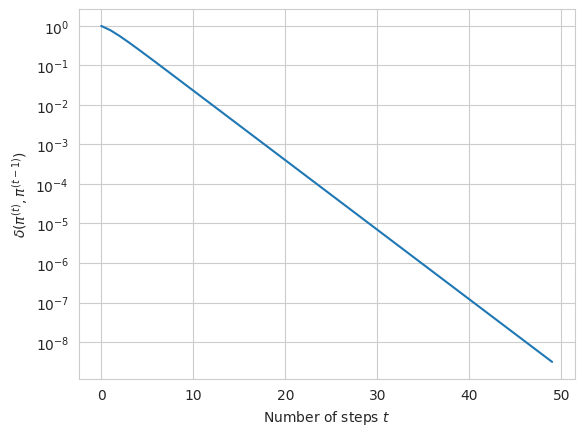

In [10]:
T = transition_matrix(g).todense()
tvds = list()
p = [1,0,0]
for t in range(50):
    p_new = np.dot(p, T)
    tvds.append(tvd(p_new, p))
    p = p_new
plt.yscale('log')
plt.xlabel('Number of steps $t$')
plt.ylabel('$\delta(\pi^{(t)}, \pi^{(t-1)})$')
plt.plot(range(50), tvds)


We find that for this network, the random walk visitation probabilities cease to change, i.e. it converges to a stationary state $\pi$. This convergence implies that the vector $\pi$ is invariant w.r.t. a multiplication with the transition matrix, i.e. 

$$\pi = \pi \cdot \mathbf{T}$$

From this equation, we see that we can compute the stationary state of a random walk by calculating the *left eigenvector of the transition matrix* corresponding to eigenvalue one. For a stochastic matrix (where all rows sum to one) the eigenvalue one is the largest eigenvalue, i.e. we can compute the stationary state of a random walk by computing the largest left eigenvalue of the transition matrix. The following function uses the `eig` function of `scipy.linalg` to compute the stationary state. Note that eigenvectors can be given in arbitrary scales, so we need to make sure that the elements sum to one if we want to interpret it as a visitation probability.

In [11]:
def stationary_distribution(network):
    T = transition_matrix(network).todense()
    eigenvalues, eigenvectors = sp.linalg.eig(T, left=True, right=False)
    # Here we take the **leading eigenvector**, i.e. the eigenvector
    # corresponding to the **largest eigenvalue** of one
    # numpy.argsort returns an array of indices that would sort an array
    # note the multi-dimensional slicing :,x, which returns all entries 
    # in column x
    pi = eigenvectors[:,np.argsort(-eigenvalues)][:,0]

    # We make sure that the eigenvector is normalised
    pi = pi/sum(pi)
    return pi

We find that this yields the stationary state that we observed in the previous notebook.

In [12]:
stationary_distribution(g)

array([0.45, 0.3 , 0.25])

The following snippet confirms that the total variation distance between $\pi^{(t)}$ and the stationary state $\pi = (0.45, 0.3, 0.25)$ converges to zero:

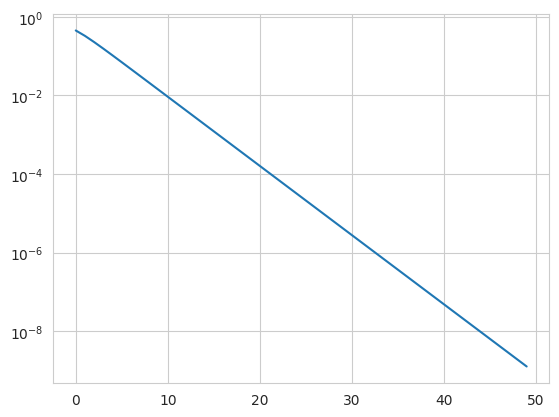

In [13]:
T = transition_matrix(g).todense()
pi = stationary_distribution(g)
tvds = list()
p = [1,0,0]
for t in range(50):
    p = np.dot(p, T)
    tvds.append(tvd(p, pi))
plt.yscale('log')
plt.plot(range(50), tvds)


The Perron-Frobenius theorem tells us that a unique stationary state exists if the transition matrix is both irreducible and aperiodic. In terms of a graph, irreducibility translates to (directed) graphs having a single (strongly) connected component. Consider the following counter-example of an undirected network with two connected components.

In [14]:
g = pp.Graph.from_edge_list([['a','b'],['a','c'],['b','c'],['d','e'],['e','f'],['d','f']])
g= g.to_undirected()

pp.plot(g, edge_color='grey')

The corresponding transition matrix has *two eigenvectors* that are associated with *two eigenvalues of one$. Those two eigenvectors represent two different stationary states that are associated with the different connected components.

In [15]:
rw = pp.processes.RandomWalk(g)
T = rw.transition_matrix.todense()
eigenvalues, eigenvectors = sp.linalg.eig(T, left=True, right=False)
print(np.sort(eigenvalues))
pi1 = eigenvectors[:,np.argsort(-eigenvalues)][:,0]
print(pi1/sum(pi1))
pi2 = eigenvectors[:,np.argsort(-eigenvalues)][:,1]
print(pi2/sum(pi2))

[-0.5+0.j -0.5+0.j -0.5+0.j -0.5+0.j  1. +0.j  1. +0.j]
[0.33333333 0.33333333 0.33333333 0.         0.         0.        ]
[0.         0.         0.         0.33333333 0.33333333 0.33333333]


If we start a random walk in the first connected component, we converge to the first stationary state.

In [16]:
for time, updated_nodes in rw.simulation_run(steps=200, seed='a'):
    pass
print(rw.visitation_frequencies)

[0.3681592  0.31840796 0.31343284 0.         0.         0.        ]


If we start in the other connected component, we converge to the second stationary state.

In [17]:
for time, updated_nodes in rw.simulation_run(steps=200, seed='d'):
    pass
print(rw.visitation_frequencies)

[0.         0.         0.         0.34825871 0.31343284 0.33830846]


In the lecture, we have further mentioned the condition that, for a unique stationary state to exist, the transition matrix must be *aperioric*. While we explain this in more detail in our course *Statistical Network Analysis* (see script on WueCampus) consider the following example for a graph where the transition matrix is not aperiodic:

In [18]:
n = pp.Graph.from_edge_list([('a', 'b'), ('b', 'c'), ('c', 'd'), ('d', 'a')])
pp.plot(n, node_label=[v for v in n.mapping.node_ids]);

Here, a random walk starting with an initial distribution $[1,0,0,0]$ will never reach a stationary state, i.e. a stationary state does not exist at least for this initial distribution, which violates the Markov Chain Convergence Theorem.

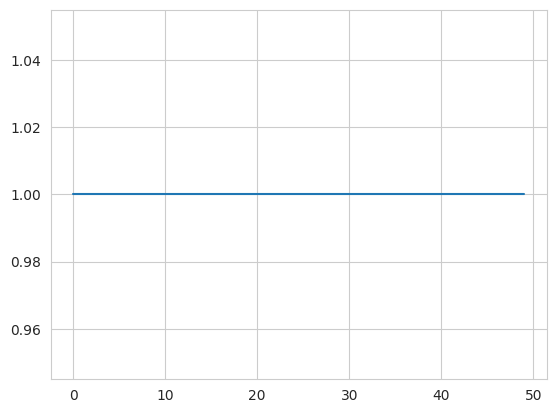

In [19]:
T = transition_matrix(n, weight=False).todense()
tvds = list()
p = [1,0,0,0]
for t in range(50):
    p_new = np.dot(p, T)
    tvds.append(tvd(p_new, p))
    p = p_new
plt.plot(range(50), tvds)


Note that there may still be a stationary state that is reached for *some* initial distributions:

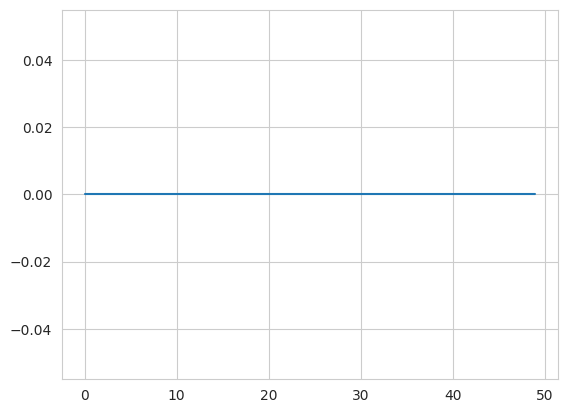

In [20]:
T = transition_matrix(n, weight=False).todense()
tvds = list()
p = [.25,.25,.25,.25]
for t in range(50):
    p_new = np.dot(p, T)
    tvds.append(tvd(p_new, p))
    p = p_new
plt.plot(range(50), tvds)

By adding self-loops to a network with a single strongly connected component, we can always ensure that the transition matrix of a random walk in a graph is both irreducible and aperiodic, i.e. that a stationary state is reached for any initial distribution. We call such a random walk `lazy` because in each step the random walker can choose whether it stays in the node (i.e. traversing via the self-loop) or whether it moves to a neighbor.

In [21]:
n = pp.Graph.from_edge_list([('a', 'b'), ('a', 'a'), ('b', 'c'), ('b', 'b'), ('c', 'd'), ('c', 'c'), ('d', 'a'), ('d', 'd')])
pp.plot(n, node_label=[v for v in n.mapping.node_ids]);

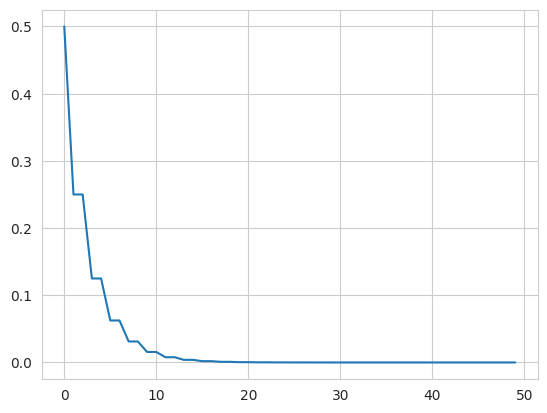

In [22]:
T = transition_matrix(n, weight=False).todense()
tvds = list()
p = [1,0,0,0]
for t in range(50):
    p_new = np.dot(p, T)
    tvds.append(tvd(p_new, p))
    p = p_new
plt.plot(range(50), tvds)